Given a set of vertical wells, perform TICC (Toeplitz Inverse Covariance Clustering)
across the same set of parameters found in each well (GR, Density, Porosity, PE, etc.).

First, determine, which wells we have in the vertical portion. Once our raw dataset is derived, 
attempt to find a proximal set of wells (i.e. where cluster density is maximized), so as to 
increase the probability of encountering similar geostructure amoungst neighboring wells.

Once the refined dataset is derived, run TICC script in parallel so as to save in computation time.
Evaluate results and determine if the sensor-to-drillbit data gap can be accurately predicted. 

In [ ]:
import json

d_drive_dataset = 'D:\horizontal drilling\datasets'

# read in maxDepth.txt and look at the data, try to see what logs are most common in vertical leg.

def findMostCommonFeature(file):
    with open(file, 'r') as f:
        d = json.loads(f.read())

    i = 0

    columnDict = {'Depth':0,
                'GR':0
                }

    for k,v in d.items():
        # only look at 1000 or so instances. 
        if i < min(1000, len(d.keys())):
            with open('..\\datasets\\scrapedWells\\'+k, 'r') as f:
                lines = f.readlines()
                try:
                    columns = lines[0].strip().split(',')[1:]
                    columnDict['Depth'] += 1
                    for _c in columns[1:]:
                        if _c not in columnDict and _c not in ['#Depth', 'DEPTH', 'DEPT']:
                            columnDict[_c] = 1
                        else:
                            columnDict[_c] += 1 
                except Exception as err:
                    pass
        # df = pd.read_csv(k, index_col=0)
        i += 1

    sortedColumnDict = dict(sorted(columnDict.items(), 
                                    key=lambda item: item[1],
                                    reverse=True))

    print(sortedColumnDict)

findMostCommonFeature('../housekeeping/maxDepths.txt')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

pd.set_option('display.float_format', lambda x: '%.3f' % x)

def find_dense_well_clusters(dataset_directory):
    # read in excel dataset from file.
    
    df = pd.read_csv(dataset_directory)

    # determine the highest well density / county.
    county_well_count = df['County/Parish'].value_counts()
    densest_county, c_num_wells = [(k,v) for k,v in county_well_count.items()][0]

    # create subset of wells in this county.
    county_wells_df = df.loc[df['County/Parish'] == densest_county]

    # redo for highest field density.
    field_well_count = county_wells_df['Field'].value_counts()
    densest_field, f_num_wells    = [(k,v) for k,v in field_well_count.items()][0]
        
    densest_field_df = county_wells_df.loc[df['Field'] == densest_field]

    # densest subplay
    subplay_well_count = densest_field_df['DI Subplay'].value_counts()
    densest_subplay, sp_num_wells    = [(k,v) for k,v in subplay_well_count.items()][0]
    densest_subplay_df = densest_field_df.loc[df['DI Subplay'] == densest_subplay]

    densest_subplay_df.to_csv('../datasets/densest_subplay.csv', index=False)
    return densest_subplay_df

def create_trajectory_directories(subplay_df):

    # just rename this for ease of use.
    df = subplay_df

    api14s = [int(api / 1e4) for api in df['API14'].tolist()]

    root_dir = 'D:\horizontal drilling\datasets\scrapedWells'

    log_folders = sorted([int(path.split('\\')[-1]) for path in glob.glob(f'{root_dir}/*')], reverse=True)

    wells_with_data = sorted(list(set(api14s) & set(log_folders)))
   
    try:
        os.mkdir('../datasets/mckenzie-county')
    except OSError:
        print('directory already exists.')
        pass
    
    for api14 in wells_with_data:
        try:
            os.mkdir(f'../datasets/mckenzie-county/{api14}')
        except OSError:
            pass
    
    return wells_with_data   

def verify_folders_have_trajectories(api14s):

    root_dir = r"C:\Users\rush\Desktop\programming\horizontal drilling\datasets\mckenzie-county"

    empty_dirs = [api14 for api14 in api14s if not os.listdir(root_dir + f'\{api14}')]

    # returns True if no empty dirs, returns the list of empty dirs if exist.

    if empty_dirs:
        return empty_dirs
    else:
        return True

def change_trajectory_filenames(api14s):

    root_dir = r"C:\Users\rush\Desktop\programming\horizontal drilling\datasets\mckenzie-county"

    naming_convention = {
        'chart.csv'     : 'total-wellhead-distance.csv',
        'chart (1).csv' : 'x-deviation.csv',
        'chart (2).csv' : 'y-deviation.csv'
    }

    for api14 in api14s:
        
        path = root_dir + f'\{api14}'
        dirs = glob.glob(path + '\\*') 

        for dir in dirs:
            try:
                key = dir.split('\\')[-1]
                
                os.rename(dir, dir.split(key)[0] + naming_convention[key])
            except KeyError as err:
                pass

if __name__ == "__main__":

    # learned that for some reason, the api14's were not properly saved somewhere along the line. so 
    # i went BACK to drillinginfo, and did the query again knowing mckenzie county was very dense.

    densest_subplay = find_dense_well_clusters(dataset_directory='../datasets/mckenzie county.CSV')

    api14s = create_trajectory_directories(densest_subplay)

    if verify_folders_have_trajectories(api14s):
        print('trajectories all accounted for.')
    else:
        print(verify_folders_have_trajectories(api14s))

    _ = change_trajectory_filenames(api14s)
    

directory already exists.
trajectories all accounted for.


In [ ]:
import shutil
# combine trajectory and associated well data.

def combine_datasets(api14s):

    d_drive_dataset = 'D:\horizontal drilling\datasets\scrapedWells'
    c_drive_dataset = r"C:\Users\rush\Desktop\programming\horizontal drilling\datasets\mckenzie-county"

    c_globs = [int(_c.split('\\')[-1]) for _c in glob.glob(c_drive_dataset + '\\*')]
    
    for i in range(len(c_globs)):
        dirs = glob.glob(d_drive_dataset + f'\\{c_globs[i]}\\*')
        for dir in dirs:
            shutil.copy(dir, c_drive_dataset + f'\{c_globs[i]}')

combine_datasets(api14s)

In [57]:
x = np.zeros((3,3))
x[1] = np.array([1,1,1])
x

array([[0., 0., 0.],
       [1., 1., 1.],
       [0., 0., 0.]])

In [67]:
import numpy as np
import csv
from IPython.display import display
import plotly.graph_objects as go
import glob
import pandas as pd
import scipy

def calculate_measured_depth(df):

    matrix = df[['x-offset', 'y-offset', 'vertical-depth']].to_numpy()
    arr = np.zeros_like(df['x-offset'])

    for i in range(1,len(arr)):
        _t = np.sqrt(np.sum(np.square(np.subtract(matrix[i], matrix[i-1]))))
        arr[i] = arr[i-1] + _t

    return arr

# when i do the matrix math to calculate cumulative distance (aka measured depth), there are 
# too few data points along the curve so we should interpolate to have a data point at each foot of MD.

def interpolate_values(df):
    
    md_min, md_max = int(df['measured-depth'].min()), int(df['measured-depth'].max())
    _range = md_max - md_min + 1

    md_mat = np.zeros((_range, len(df.columns)))
    
    for _, row in df.iterrows():
        # idx here refers to the MD, where we will then use this MD to idx the md_mat 
        idx = int(row['measured-depth'])
        r    = np.array(row)
        md_mat[idx] = r

    x = np.arange(0, md_mat.shape[0])
    xnew = np.linspace(x.min(), x.max(), len(x))
    f = scipy.interpolate.interp1d(x, md_mat, axis=0)

    df = pd.DataFrame(f)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(df)
    return md_mat

def combine_coordinates(root_dir, disp=False):

    # traverse directories and collect trajectory files
    
    sub_dirs = glob.glob(root_dir + '\\*.csv')
    
    # define naming convention for final data arrays.
    naming_convention = {
        'total-wellhead-distance.csv': 'total-depth',
        'x-deviation.csv'            : 'x-offset',
        'y-deviation.csv'            : 'y-offset'
    }

    mapping = {
        naming_convention[sub_dirs[i].split('\\')[-1]]: i for i in range(len(sub_dirs))
    }

    # recreate dictionary so as to edit dict in-situ and not throw error.
    _mapping = mapping.copy()

    # iterate over individual csv files and input into mapping dictionary for df conversion.
    for k,v in naming_convention.items():

        with open(root_dir + f'\\{k}', newline='') as csvfile:
            data = list(csv.reader(csvfile))[1:]

            # first index will always be depth then trajectory of specific coordinate.
            # therefore, if not v i.e. index = 0, insert array into copy dict.
            _d = np.array([float(i[0]) for i in data])
            _t = np.array([float(i[1]) for i in data])
        
        if not mapping[naming_convention[k]]:
            
            _mapping['vertical-depth'] = _d
                
        _mapping[naming_convention[k]] = _t
        
    df = pd.DataFrame(_mapping)

    df['distance'] = np.sqrt(df['x-offset'] ** 2 + df['y-offset'] ** 2 + df['vertical-depth'] ** 2)

    df = df.sort_values(by=['distance']).reset_index(drop=True)

    df['measured-depth'] = calculate_measured_depth(df)

    _ = interpolate_values(df)

    if disp:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(df)
    
    return df

root_dir = rf"C:\Users\rush\Desktop\programming\horizontal drilling\datasets\mckenzie-county\\{3305303272}"
    
df = combine_coordinates(root_dir, disp=True)


ValueError: DataFrame constructor not properly called!

In [50]:
# visualize an individual well

def visualize_individual_well_3d(api14):

    root_dir = rf"C:\Users\rush\Desktop\programming\horizontal drilling\datasets\mckenzie-county\\{api14}"
    
    df = combine_coordinates(root_dir, disp=False)
    
    # when you plot this, it can get really wonky based on the scaling of it because the primary lateral direction (i.e. y-offset)
    # may be multiple orders of magnitude >> the opposing axis (i.e. y = 10000, x = 100). wells go both north-south and east-west
    # so determine the primary direction, then scale the secondary axis up an order of magnitude so as not to distort the visual. 

    y_range = abs(df['y-offset'].min() - df['y-offset'].max())
    x_range = abs(df['x-offset'].min() - df['x-offset'].max())

    scaling_ratio = 5

    if y_range > x_range: 

        x_avg = np.average(df['x-offset'])
        
        x_range = [x_avg - y_range // scaling_ratio, x_avg + y_range // scaling_ratio]

        if df['x-offset'].min() < x_range[0] or df['x-offset'].max() > x_range[1] :

            x_range = [df['x-offset'].min(), df['x-offset'].max()]

        primary_axis = 0
    
    else:

        y_avg = np.average(df['y-offset'])

        y_range = [y_avg - x_range // scaling_ratio, y_avg + x_range // scaling_ratio]

        if df['y-offset'].min() < y_range[0] or df['y-offset'].max() > y_range[1] :

            y_range = [df['y-offset'].min(), df['y-offset'].max()]

        primary_axis = 1

    fig = go.Figure(data=go.Scatter3d(
                    x=df['x-offset'], y=df['y-offset'], z=-df['vertical-depth'],mode='markers',
                    line=dict(
                        color='darkblue',
                        width=2
                    ),
                    ))
    
    fig.update_layout(
    width=2000,
    height=1000,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=0,
                y=1.0707,
                z=1,
            )
        ),    
    ),
    )

    if not primary_axis:
         fig.update_layout(
            scene=dict(
                xaxis = dict(nticks=4, range=x_range)
            )
         )
        
    else:
        fig.update_layout(
            scene=dict(
                yaxis = dict(nticks=4, range=y_range)
            )
         )

    fig.show()

visualize_individual_well_3d(api14s[4])

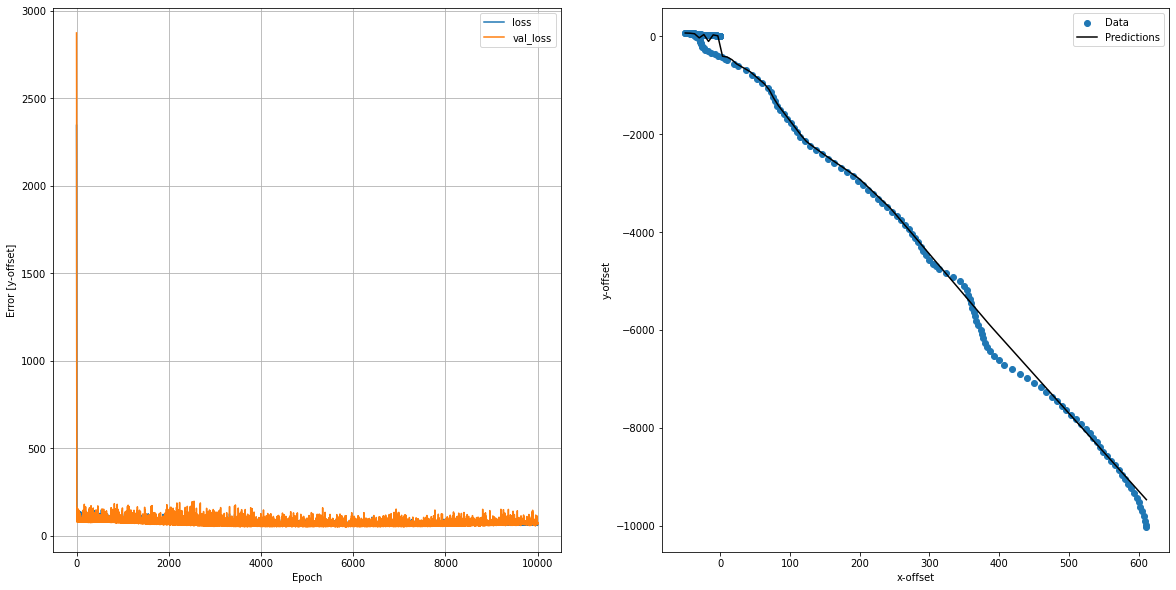

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

def plot_dnn_function(dataset, dnn_model, history):

    fig = plt.figure(figsize=(20,10))
    
    ax1 = fig.add_subplot(121)
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [y-offset]')
    ax1.legend()
    ax1.grid(True)

    x_min = dataset['x-offset'].min()
    x_max = dataset['x-offset'].max()

    x = np.linspace(x_min, x_max, 100)
    test_predictions = dnn_model.predict(x)

    ax2 = fig.add_subplot(122)
    ax2.scatter(dataset['x-offset'], dataset['y-offset'], label='Data')
    ax2.plot(x, test_predictions, color='k', label='Predictions')
    ax2.set_xlabel('x-offset')
    ax2.set_ylabel('y-offset')
    ax2.legend()
    
    return test_predictions, x, 

def plot_3d_scatter(test_features, test_predictions):

    fig = go.Figure(data=go.Scatter3d(
                    x=test_features['x-offset'], y=test_predictions, z=-test_features['vertical-depth'],mode='markers',
                    marker=dict(
                        color='darkblue',
                        size=5
                    ),
                    ))
    
    fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=0,
                y=1.0707,
                z=1,
            )
        ),
        xaxis = dict(
            nticks=4, range=[-1e2,1e2]
        )
    ),
    )

    fig.show()


def visualize_individual_well_2d(api14):

    root_dir = rf"C:\Users\rush\Desktop\programming\horizontal drilling\datasets\mckenzie-county\\{api14}"
    
    df = combine_coordinates(root_dir)

    # derive nonlinear function where we use one offset to predict the other, this fixes the problem of data being
    # improperly ordered when it was transferred or recorded. this is easy to see when you plot trajectory via 
    # a line in 2d vs a scatter plot in 2d. we can use elastic net regression to fix this. 

    df.drop(['total-depth'], axis=1)

    dataset = df.copy()

    train_dataset = dataset.sample(frac=0.8, random_state=0)
    test_dataset = dataset.drop(train_dataset.index)
    
    train_features = train_dataset.copy()
    test_features = test_dataset.copy()

    train_labels = train_features.pop('y-offset')
    test_labels = test_features.pop('y-offset')

    normalizer = tf.keras.layers.Normalization(axis=-1)

    dnn_model = build_and_compile_model(normalizer)

    history = dnn_model.fit(
        train_features['x-offset'],
        train_labels,
        validation_split=0.2,
        steps_per_epoch = 10,
        shuffle=True,
        verbose=0, epochs=10000)

    test_predictions = plot_dnn_function(dataset, dnn_model, history)

    # plot_3d_scatter(test_features, test_predictions)


visualize_individual_well_2d(api14s[2])

In [7]:
root_dir = rf"C:\Users\rush\Desktop\programming\horizontal drilling\datasets\mckenzie-county\\{api14}"
    
df = combine_coordinates(root_dir)

print(df)

NameError: name 'api14' is not defined